In [12]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import numpy as np

import dataset
import rendering
import model
import train

In [13]:
test_origin, test_direction, test_target_px_values = dataset.get_rays('../dataset/fox', mode='test')

Mode: test
Image files length: 10
Pose files length: 10
Intrinsic files length: 10
Image size: (400, 400, 4)
(10, 400, 400, 4)


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nerf_model = torch.load('../models/model_nerf').to(device)
nerf_model.eval()

Nerf(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=257, bias=True)
  )
  (rgb_head): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
    (3): Si

### running the model for inference takes 8GB ram
- images are 400 * 400 = 160000 rays for each pixel
- for each ray we need 100 binned samples
- 400 * 400 * 100 = 16 million points points into neural network


#### instead of doing 16 million at the same time we will use batching to address the memory issue
- therefore instead of 16M we do 1.6M in each batch 
- this one the main issues with nerf: this causes the FPS of nerf to be very low
    - about 0.5 to 0.1 fps for any practical application
    - movies are roughly 24 fps, therefore for real time we need to decrease inference times
    - recently new methods have made it possible to render at 200 FPS!

### since MSELoss is hard to interpret
### Compute PSNR instead 
 - that are used to report in nerf papers
 - easier to interpret than mse.

In [15]:
def mse2psnr(mse_loss):
    return 20 * np.log10(1 / np.sqrt(mse_loss))

In [16]:
@torch.inference_mode() #dont need to computre gradients
def test(model, origin, direction, tn, tf, nb_bins=100, chunk_size=20, height=400, width=400, target=None):
   
    with torch.inference_mode():
        model.eval()
        origin = origin.chunk(chunk_size)
        direction = direction.chunk(chunk_size)
        
        image = []
        for origin_batch, direction_batch in zip(origin, direction): #zip to interate both lists at the same time
            img_batch = rendering.rendering(model, origin_batch, direction_batch, tn, tf, nb_bins, device=origin_batch.device)
            image.append(img_batch) #[N, 3]
                    
        image = torch.cat(image) # [H*W, 3]
        image = image.reshape(height, width, 3).cpu().numpy() #no need for .data as there are no gradients!
        
        if target is not None:
            # mse = nn.MSELoss()
            # loss = mse(image, target)
            loss = ((image - target)**2).mean() #same as mean squared errorfunction
            psnr = mse2psnr(loss)
            return image, loss, psnr
        
        else:
            return image

### Chunking the input tensors into 1/20 their size to fit 6GB GPU VRAM

In [17]:
print(f"Pre-Chunking shape:{test_origin[0].shape}")
print(f"After Chunking size:{torch.from_numpy(test_origin[0]).chunk(20)[0].shape}")
#almost 0.05 times the size

Pre-Chunking shape:(160000, 3)
After Chunking size:torch.Size([8000, 3])


In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#hyperparams
tn = 8
tf = 12
nb_epochs = 15
learning_rate = 1e-3
gamma = 0.5
nb_bins = 100

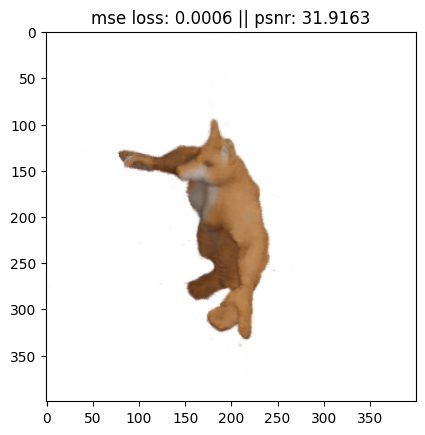

In [23]:
img, mse, psnr = test(nerf_model,
     torch.from_numpy(test_origin[0]).to(device).float(),
     torch.from_numpy(test_direction[0]).to(device).float(),
     tn, tf,
     nb_bins=100,
     chunk_size=20,
     target=test_target_px_values[0].reshape(400, 400, 3))

plt.title(f"mse loss: {mse:.4f} || psnr: {psnr:.4f}")
plt.imshow(img)

## target real image

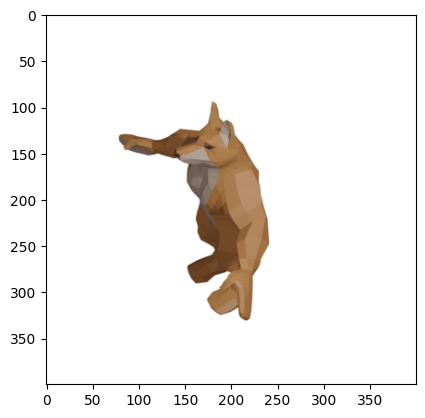

In [12]:
plt.imshow(test_target_px_values[0].reshape(400, 400, 3))

### Plot the difference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


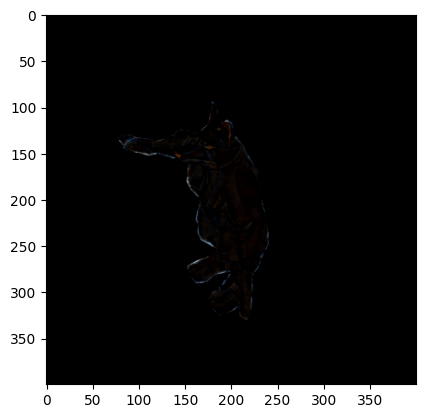

In [13]:
plt.imshow(img - test_target_px_values[0].reshape(400, 400, 3))

In [19]:
voxel_model = torch.load('../models/model_voxels').to(device)
voxel_model.voxels.device

device(type='cuda', index=0)

In [21]:

img, mse, psnr = test(voxel_model,
     torch.from_numpy(test_origin[0]).to(device).float(),
     torch.from_numpy(test_direction[0]).to(device).float(),
     tn, tf,
     nb_bins=100,
     chunk_size=20,
     target=test_target_px_values[0].reshape(400, 400, 3))

plt.title(f"mse loss: {mse:.4f} || psnr: {psnr:.4f}")
plt.imshow(img)

TypeError: Voxels.intersect() takes 2 positional arguments but 3 were given